# Connecting Rods

In [1007]:
def handle_touching_rods(imgf):
    img, contours, hierarchy = cv.findContours(imgf.copy(), cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

    # get the contour index of touching rods
    # TODO: handle multiple touching rods using list
    sepc = -1
    for i in range(len(contours)):
        if(len(contours[i])) >= 256: # there are touching elements
            sepc = i
            break

    collision_points = []
    
    if sepc != -1: # if there are touching rods, add them
        for i in range(len(contours[sepc])):
            if (contours[sepc][i][0][0] - 1 >= 0) and (contours[sepc][i][0][1] - 1 >= 0) and (contours[sepc][i][0][0] + 1 <= 255) and (contours[sepc][i][0][1] + 1 <= 255):
                if int(img[contours[sepc][i][0][1] - 1, contours[sepc][i][0][0]]) + int(img[contours[sepc][i][0][1] - 1, contours[sepc][i][0][0] - 1]) + int(img[contours[sepc][i][0][1], contours[sepc][i][0][0] - 1]) + int(img[contours[sepc][i][0][1] + 1, contours[sepc][i][0][0] - 1]) + int(img[contours[sepc][i][0][1] + 1, contours[sepc][i][0][0]]) + int(img[contours[sepc][i][0][1] + 1, contours[sepc][i][0][0] + 1]) + int(img[contours[sepc][i][0][1], contours[sepc][i][0][0] + 1]) + int(img[contours[sepc][i][0][1] - 1, contours[sepc][i][0][0] + 1]) == 255 or int(img[contours[sepc][i][0][1] - 1, contours[sepc][i][0][0]]) + int(img[contours[sepc][i][0][1] - 1, contours[sepc][i][0][0] - 1]) + int(img[contours[sepc][i][0][1], contours[sepc][i][0][0] - 1]) + int(img[contours[sepc][i][0][1] + 1, contours[sepc][i][0][0] - 1]) + int(img[contours[sepc][i][0][1] + 1, contours[sepc][i][0][0]]) + int(img[contours[sepc][i][0][1] + 1, contours[sepc][i][0][0] + 1]) + int(img[contours[sepc][i][0][1], contours[sepc][i][0][0] + 1]) + int(img[contours[sepc][i][0][1] - 1, contours[sepc][i][0][0] + 1]) == 510:
                    collision_points.append([contours[sepc][i], False])

    if len(collision_points) > 0:
        # calculate euclidean distance
        for i in range(len(collision_points) - 1):
            distance_from_i_to_j = math.inf
            index_of_j = -1
            if collision_points[i][1] == False: # means that still need to find its miniumum distance point
                for j in range(i + 1, len(collision_points)):
                    dst = distance.euclidean(collision_points[i][0][0], collision_points[j][0][0])
                    if dst < distance_from_i_to_j and collision_points[j][1] == False:
                        distance_from_i_to_j = dst
                        index_of_j = j
                # draw line
                cv.line(img,(collision_points[i][0][0][0],collision_points[i][0][0][1]),(collision_points[index_of_j][0][0][0],collision_points[index_of_j][0][0][1]),(255,0, 0),1)
                collision_points[i][1] = True
                collision_points[index_of_j][1] = True
    return img

### Original mage

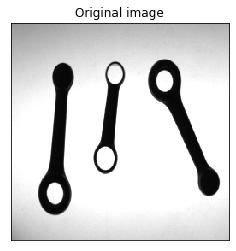

In [1008]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial import distance
import math

plt.figure(figsize=(4,4))

original_img = cv.imread('testImages/TESI00.BMP', 0)
img = original_img.copy()
plt.imshow(img, cmap='gray',vmin=0,vmax=255)
plt.title('Original image'), plt.xticks([]), plt.yticks([])
plt.show()

### Apply Otsu's tresholding

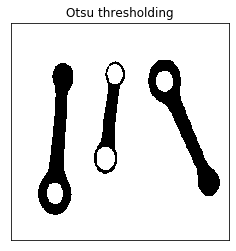

In [1009]:
ret, otsu_img = cv.threshold(img, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
plt.imshow(imgf,cmap = 'gray')
plt.title('Otsu thresholding'), plt.xticks([]), plt.yticks([])
plt.show()

### Apply dilation

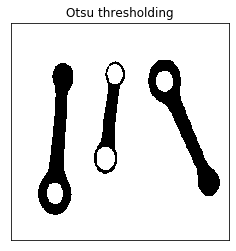

In [1010]:
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(1,1))
dilated_image = cv.erode(otsu_img, kernel, iterations=1)
plt.imshow(dilated_image, cmap = 'gray')
plt.title('Otsu thresholding'), plt.xticks([]), plt.yticks([])
plt.show()

### Handling touching elements

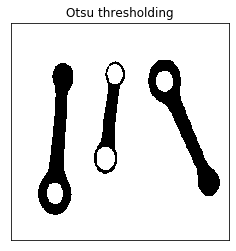

In [1011]:
separate_rods_img = handle_touching_rods(dilated_image)
plt.imshow(imgf2,cmap = 'gray')
plt.title('Otsu thresholding'), plt.xticks([]), plt.yticks([])
plt.show()

### Labeling rods

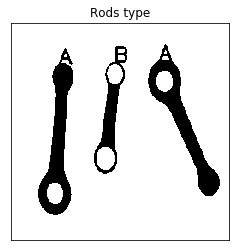

In [1012]:
img, contours, hierarchy = cv.findContours(separate_rods_img.copy(), cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
for i in range(hierarchy.shape[1]):
    if hierarchy[0, i][3] == 0 and hierarchy[0, i][2] != -1 and len(contours[i]) >= 72:
        if len(hierarchy[:, np.where(hierarchy[0][:, 3] == i)][0][0]) == 1:
            img = cv.putText(img, 'A', (contours[i][0][0][0], contours[i][0][0][1]), cv.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2, cv.LINE_4)
            plt.imshow(img,cmap = 'gray')
            plt.title('Rods type'), plt.xticks([]), plt.yticks([])
        elif len(hierarchy[:, np.where(hierarchy[0][:, 3] == i)][0][0]) > 1:
            img = cv.putText(img, 'B', (contours[i][0][0][0], contours[i][0][0][1]), cv.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2, cv.LINE_4)
            plt.imshow(img,cmap = 'gray')
            plt.title('Rods type'), plt.xticks([]), plt.yticks([])
            
plt.show()

## Position, orientation, length, width and width at the barycenter Wb 

Position:  (51.93987274169922, 136.43801879882812) , Orientation:  -89.12532043457031
Length:  179.19285583496094 , Width:  40.0869255065918 , Width at the barycenter:  38.096038818359375
------------------------------------------------------------------------------------------------
Position:  (114.32376861572266, 111.43852996826172) , Orientation:  -84.80557250976562
Length:  133.72129821777344 , Width:  28.971439361572266 , Width at the barycenter:  27.27679443359375
------------------------------------------------------------------------------------------------
Position:  (200.18011474609375, 124.6065673828125) , Orientation:  -20.400209426879883
Length:  171.22802734375 , Width:  41.65089416503906 , Width at the barycenter:  35.01091384887695
------------------------------------------------------------------------------------------------


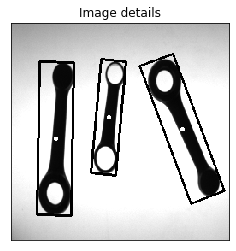

In [1013]:
img = original_img.copy()
for i in range(hierarchy.shape[1]):
    if hierarchy[0, i][3] == 0 and hierarchy[0, i][2] != -1 and len(contours[i]) >= 72:
        rect = cv.minAreaRect(contours[i])
        box = cv.boxPoints(rect)
        box = np.int0(box)
        img = cv.drawContours(img,[box],0,(0, 255, 0), 2)
        (x, y),(MA, ma),angle = cv.fitEllipse(contours[i])
        print("Position: ", rect[0], ", Orientation: ", rect[2])
        print("Length: ", rect[1][0] if rect[1][0] > rect[1][1] else rect[1][1], ", Width: ", 
              rect[1][1] if rect[1][1] < rect[1][0] else rect[1][0], ", Width at the barycenter: ", MA)
        print("------------------------------------------------------------------------------------------------")
        # draw barycenter
        img = cv.circle(img, center=(round(rect[0][0]), round(rect[0][1])), radius=1, color=(255, 0, 0) , thickness=2) 
        plt.imshow(img, cmap = 'gray')
        plt.title('Image details'), plt.xticks([]), plt.yticks([])
plt.show()

### For each hole, position of the centre and diameter size

Centre position:  (51.0, 200.0)
Diameter:  18.506450653076172
------------------------------------------------------------------------------------------------
Centre position:  (110.0, 159.0)
Diameter:  20.418180465698242
------------------------------------------------------------------------------------------------
Centre position:  (121.10002136230469, 60.20000457763672)
Diameter:  17.5764217376709
------------------------------------------------------------------------------------------------
Centre position:  (179.0, 69.0)
Diameter:  18.850460052490234
------------------------------------------------------------------------------------------------


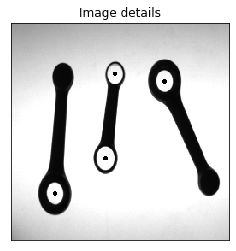

In [1014]:
img = original_img.copy()
for i in range(hierarchy.shape[1]):
    if hierarchy[0, i][3] > 0 and len(contours[i]) > 24 and len(contours[hierarchy[0, i][3]]) >= 72: # if the parent of the hole has a perimeter greater than 72 (basically here I am verifying whether the hole's parent is a rod)
        rect = cv.minAreaRect(contours[i])
        box = cv.boxPoints(rect)
        box = np.int0(box)
        (x, y),(MA, ma),angle = cv.fitEllipse(contours[i])
        print("Centre position: ", rect[0])
        print("Diameter: ", MA)
        print("------------------------------------------------------------------------------------------------")
        # draw barycenter
        img = cv.circle(img, center=(round(rect[0][0]), round(rect[0][1])), radius=1, color=(0, 255, 0) , thickness=2) 
        plt.imshow(img, cmap = 'gray')
        plt.title('Image details'), plt.xticks([]), plt.yticks([])
plt.show()

max noise contour == 12

min non noise contour == 35

threshold = (12 + 35) / 2 -> 24

-------

hierarchy[0, i][3] == 0 : if my parent is zero, it means that I'am a rod. <br>
hierarchy[0, i][2] != -1 : if a rod has a first child, it means it is a rod and not a bolt, so it will be analyzed. <br>
len(contours[i]) >= 72 : of the perimeter of the blob took into account is greater than the empirical value 72, it means that it is a rod an not a washers, so it will be analyzed.

------

max area rondella == 64

min area biella == 80

threshold = (64 + 80) / 2 -> 72

------

max area biella == 256

min area touching bielle == 397

threshold for touching elements: (256 + 397) / 2 -> 326